# Data Analysis Example in Python
### Adapted by Carrie Brown from "The Bigmemory Project: Introductory Example" by Michael Kane and John Emerson

Using USA Commerical Flight Data from 1997 to 2008, this analysis covers data loading, integration and basic visualization to attempt to discern possible causes of flight delays.

**If you wish to run this notebook interactively:** you will be need to run the `get_data.submit` job (using the command `sbatch get_data.submit`) to download the necessary datafiles. It is also recommended to change the data load step to use the truncated data set to improve run times.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

# Set plot figure sizes
plt.rcParams["figure.figsize"] = (10,10)

In [2]:
# Load airline.csv data - to run this interactively, change the file to './data/airline_truc.csv'
flights = pd.read_csv("./data/airline_subsample.csv",
                     sep = ",", low_memory=False)
flights.head(5)

,Year,Month,TailNum,ArrDelay,Origin
0,1987,10,NaN,NaN,JFK
1,1987,11,NaN,2.0,MCI
2,1987,11,NaN,0.0,SAN
3,1987,12,NaN,31.0,ORD
4,1987,10,NaN,12.0,LAX


In [3]:
# The structure of the dataframe
flights.dtypes

Year          int64
Month         int64
TailNum      object
ArrDelay    float64
Origin       object
dtype: object

In [4]:
# Number of rows and columns in dataframe
flights.shape

(2200000, 5)

In [5]:
# Remove flights with missing data
flights = flights.dropna(axis = [0, 1], how = "any")
flights.shape

(1366016, 5)

In [6]:
# Function to estimate birthmonth of aircraft by finding the month and year of first flight
def birthmonth(airplane):
    minYear = airplane['Year'].min()
    minMonth = airplane[airplane['Year'] == minYear]['Month'].min()
    return (12*minYear + minMonth - 1);

# Create vectors for each aircraft (aircrafts)
aircrafts = flights['TailNum'].unique()
aircrafts = [s for s in aircrafts if str(s) != 'nan']

aircrafts[1:10]

['N605AU',
 'N178AW',
 'N966VJ',
 'N903DE',
 'N997Z',
 'N57837',
 'N948L',
 'N945DL',
 'N309']

In [7]:
# Calculate Age of each airline at time of flight
flights['Start'] = np.nan

for x in aircrafts:
    birthday = (birthmonth(flights[flights['TailNum'] == x]))
    flights.loc[flights.TailNum == x, 'Start'] = birthday

flights = flights.assign(Age = flights.Year * 12 + flights.Month - flights.Start)
    
flights[1:10]

,Year,Month,TailNum,ArrDelay,Origin,Start,Age
800001,1995,12,N605AU,108.0,TPA,23940.0,12.0
800002,1995,10,N178AW,1.0,PHX,23940.0,10.0
800003,1995,11,N966VJ,-7.0,PIT,23940.0,11.0
800004,1995,1,N903DE,-4.0,PNS,23940.0,1.0
800005,1995,2,N997Z,7.0,AUS,23941.0,1.0
800006,1995,7,N57837,-14.0,MCO,23940.0,7.0
800007,1995,7,N948L,-15.0,CID,23940.0,7.0
800008,1995,12,N945DL,18.0,LGA,23940.0,12.0
800009,1995,3,N309,60.0,PHX,23940.0,3.0


In [8]:
# Remove flights with Age of 1
flights_subset = flights[(flights['Age']!=1.0)]

flights_subset.shape

(1332628, 7)

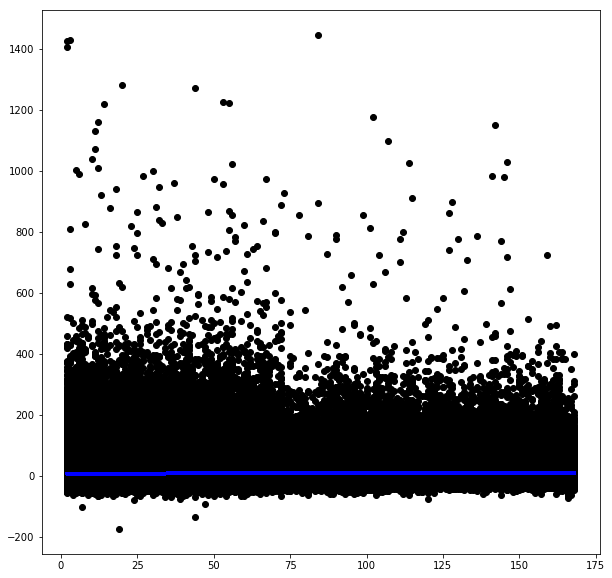

0.00020628710246184401

In [9]:
# Generate linear model for response: ArrDelay and predictors: Age
x = flights_subset.Age.values
y = flights_subset.ArrDelay.values

x = x.reshape(len(x), 1)
y = y.reshape(len(y), 1)

lm = LinearRegression()
lm.fit(x, y)

# Create scatter plot
plt.scatter(x, y,  color='black')
plt.plot(x, lm.predict(x), color='blue', linewidth=3)
plt.show()

# View the Rsquared value for the regression equation
lm.score(x, y)

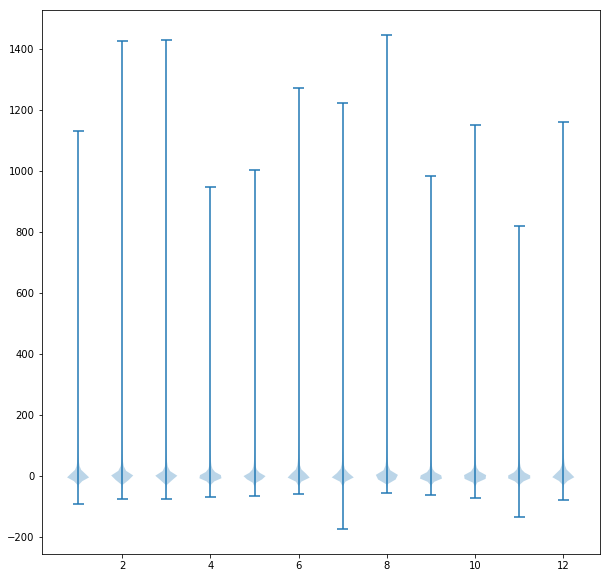

In [10]:
# Create violin plot showing delay by month
flights_subset = []

for x in np.unique(flights[["Month"]].values):
    flights_subset.append(flights[flights["Month"] == x]["ArrDelay"].values)

fig, axes = plt.subplots()
axes.violinplot(flights_subset, positions=np.unique(flights[["Month"]].values))
plt.show()

In [11]:
# Determine range of ArrDelay
print("Minimum delay:", flights["ArrDelay"].min(),"Maximum delay:", flights["ArrDelay"].max())

('Minimum delay:', -175.0, 'Maximum delay:', 1445.0)


In [12]:
# Bin ArrDelay
bins = [-50,-15,30,120,500]
bin_names = ["Early","On-Time", "Late", "Very Late"]
flights["ArrCategory"] = pd.cut(flights["ArrDelay"], bins, labels = bin_names)

flights[1:10]

,Year,Month,TailNum,ArrDelay,Origin,Start,Age,ArrCategory
800001,1995,12,N605AU,108.0,TPA,23940.0,12.0,Late
800002,1995,10,N178AW,1.0,PHX,23940.0,10.0,On-Time
800003,1995,11,N966VJ,-7.0,PIT,23940.0,11.0,On-Time
800004,1995,1,N903DE,-4.0,PNS,23940.0,1.0,On-Time
800005,1995,2,N997Z,7.0,AUS,23941.0,1.0,On-Time
800006,1995,7,N57837,-14.0,MCO,23940.0,7.0,On-Time
800007,1995,7,N948L,-15.0,CID,23940.0,7.0,Early
800008,1995,12,N945DL,18.0,LGA,23940.0,12.0,On-Time
800009,1995,3,N309,60.0,PHX,23940.0,3.0,Late


In [13]:
### Create Random Forest for response: ArrDelay and predictors: Month, Year and Age

# Create training and testing subsets
X = flights[['Month', 'Year', 'Age']]
y = flights["ArrDelay"]

forest = RandomForestClassifier(max_depth = 3)
forest.fit(X, y)

# Importance of each feature: 'Month', 'Year', and 'Age'
forest.feature_importances_

array([ 0.19874725,  0.61602479,  0.18522797])